In [ ]:
import pandas as pd
import numpy as np
from pulp import *
import matplotlib.pyplot as plt
import random
random.seed(1447)

In [ ]:
!pip install pulp

In [ ]:
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_columns', None)
pd.options.display.max_seq_items = 2000

In [ ]:
%%html
<style>
.dataframe td {
    white-space: nowrap;
}
</style>

## Import Data

#### Manufacturing variable costs

In [ ]:
# Import Costs
manvar_costs = pd.read_excel('variable costs.xlsx', index_col = 0)
manvar_costs

,USA,GERMANY,JAPAN,BRAZIL,INDIA
Variable Costs ($/Unit),,,,,
USA,12,12,12,12,12
GERMANY,13,13,13,13,13
JAPAN,10,10,10,10,10
BRAZIL,8,8,8,8,8
INDIA,5,5,5,5,5


#### Freight costs

In [ ]:
# Import Costs
freight_costs = pd.read_excel('freight costs.xlsx', index_col = 0)
freight_costs

,USA,GERMANY,JAPAN,BRAZIL,INDIA
Freight Costs ($/Container),,,,,
USA,0,1750,1100,2300,1254
GERMANY,1905,0,1231,2892,1439
JAPAN,2200,3250,0,6230,2050
BRAZIL,2350,3150,4000,0,4250
INDIA,1950,2200,3500,4200,0


#### Variable Costs

In [ ]:
# Factory + Freight Variable Costs
var_cost = freight_costs/1000 + manvar_costs
var_cost

,USA,GERMANY,JAPAN,BRAZIL,INDIA
Freight Costs ($/Container),,,,,
USA,12.000,13.75,13.100,14.300,13.254
GERMANY,14.905,13.00,14.231,15.892,14.439
JAPAN,12.200,13.25,10.000,16.230,12.050
BRAZIL,10.350,11.15,12.000,8.000,12.250
INDIA,6.950,7.20,8.500,9.200,5.000


#### Fixed Costs

In [ ]:
# Factory Fixed Costs
fixed_costs = pd.read_excel('fixed cost.xlsx', index_col = 0)
fixed_costs

,LOW,HIGH
USA,6500,9500
GERMANY,4980,7270
JAPAN,6230,9100
BRAZIL,3230,4730
INDIA,2110,6160


#### Plants Capacity

In [ ]:
# Two types of plants: Low Capacity and High Capacity Plant
cap = pd.read_excel('capacity.xlsx', index_col = 0)
cap

,LOW,HIGH
Capacity (kUnits/month),,
USA,500,1500
GERMANY,500,1500
JAPAN,500,1500
BRAZIL,500,1500
INDIA,500,1500


#### Demand

In [ ]:
demand = pd.read_excel('demand.xlsx', index_col = 0)
demand

,Demand
(Units/month),
USA,2800000
GERMANY,90000
JAPAN,1700000
BRAZIL,145000
INDIA,160000


---

## Initial Calculation
(1 Scenario)

In [ ]:
# Define Decision Variables
loc = ['USA', 'GERMANY', 'JAPAN', 'BRAZIL', 'INDIA']
size = ['LOW', 'HIGH']
plant_name = [(i,s) for s in size for i in loc]
prod_name = [(i,j) for i in loc for j in loc]

# Initialize Class
model = LpProblem("Capacitated Plant Location Model", LpMinimize)


# Create Decision Variables
x = LpVariable.dicts("production_", prod_name,
                     lowBound=0, upBound=None, cat='continuous')
y = LpVariable.dicts("plant_",
                     plant_name, cat='Binary')

# Define Objective Function
model += (lpSum([fixed_costs.loc[i,s] * y[(i,s)] * 1000 for s in size for i in loc])
          + lpSum([var_cost.loc[i,j] * x[(i,j)]   for i in loc for j in loc]))

# Add Constraints
for j in loc:
    model += lpSum([x[(i, j)] for i in loc]) == demand.loc[j,'Demand']
for i in loc:
    model += lpSum([x[(i, j)] for j in loc]) <= lpSum([cap.loc[i,s]*y[(i,s)] * 1000
                                                       for s in size])

# Solve Model
model.solve()
print("Status: {}".format(LpStatus[model.status]))
print("Total Costs: {:,} ($/Month)".format(int(value(model.objective))))

# Results Plant (Boolean)
df_bool = pd.DataFrame(data = [y[plant_name[i]].varValue for i in range(len(plant_name))], index = [i + '-' + s for s in size for i in loc],
                        columns = ['Plant Opening'])
df_bool

Status: Optimal
Total Costs: 65,118,000 ($/Month)


/usr/local/lib/python3.11/dist-packages/pulp/pulp.py:1424: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


,Plant Opening
USA-LOW,0.0
GERMANY-LOW,0.0
JAPAN-LOW,0.0
BRAZIL-LOW,0.0
INDIA-LOW,1.0
USA-HIGH,0.0
GERMANY-HIGH,0.0
JAPAN-HIGH,1.0
BRAZIL-HIGH,1.0
INDIA-HIGH,1.0


#### Plant Opening

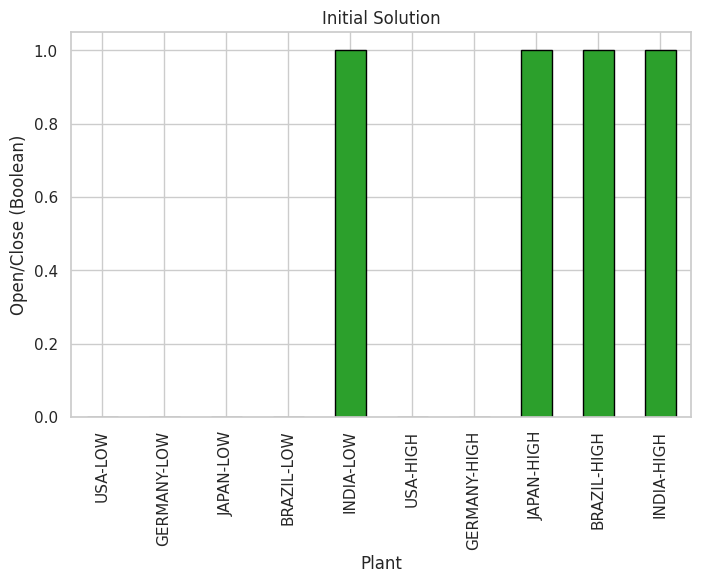

In [ ]:
# Plant Opening
cap_plot = cap.copy()

ax = df_bool.astype(int).plot.bar(figsize=(8, 5), edgecolor='black', color = 'tab:green', y='Plant Opening', legend= False)
plt.xlabel('Plant')
plt.ylabel('Open/Close (Boolean)')
plt.title('Initial Solution')
plt.show()

---

### Functions to simulate several scenarios
#### Funtion to build the model

In [ ]:
def optimization_model(fixed_costs, var_cost, demand, demand_col, cap):
    '''Build the optimization based on input parameters'''
    # Define Decision Variables
    loc = ['USA', 'GERMANY', 'JAPAN', 'BRAZIL', 'INDIA']
    size = ['LOW', 'HIGH']
    plant_name = [(i,s) for s in size for i in loc]
    prod_name = [(i,j) for i in loc for j in loc]

    # Initialize Class
    model = LpProblem("Capacitated Plant Location Model", LpMinimize)

    # Create Decision Variables
    x = LpVariable.dicts("production_", prod_name,
                         lowBound=0, upBound=None, cat='continuous')
    y = LpVariable.dicts("plant_",
                         plant_name, cat='Binary')

    # Define Objective Function
    model += (lpSum([fixed_costs.loc[i,s] * y[(i,s)] * 1000 for s in size for i in loc])
              + lpSum([var_cost.loc[i,j] * x[(i,j)]   for i in loc for j in loc]))

    # Add Constraints
    for j in loc:
        model += lpSum([x[(i, j)] for i in loc]) == demand.loc[j,demand_col]
    for i in loc:
        model += lpSum([x[(i, j)] for j in loc]) <= lpSum([cap.loc[i,s]*y[(i,s)] * 1000
                                                           for s in size])
    # Solve Model
    model.solve()

    # Results
    status_out = LpStatus[model.status]
    objective_out  = pulp.value(model.objective)
    plant_bool = [y[plant_name[i]].varValue for i in range(len(plant_name))]
    fix = sum([fixed_costs.loc[i,s] * y[(i,s)].varValue * 1000 for s in size for i in loc])
    var = sum([var_cost.loc[i,j] * x[(i,j)].varValue for i in loc for j in loc])
    plant_prod = [x[prod_name[i]].varValue for i in range(len(prod_name))]
    return status_out, objective_out, y, x, fix, var

[link text](https://)#### Build the normal distribution of demand: N(demand, demand x COV)

In [ ]:
# Normal Distribution
N = 50
df_demand = pd.DataFrame({'scenario': np.array(range(1, N + 1))})
data = demand.reset_index()
# Demand
CV = 0.5
markets = data['(Units/month)'].values
for col, value in zip(markets, data['Demand'].values):
    sigma = CV * value
    df_demand[col] = np.random.normal(value, sigma, N)
    df_demand[col] = df_demand[col].apply(lambda t: t if t>=0 else 0)

# Add Initial Scenario
COLS = ['scenario'] + list(demand.index)
VALS = [0] + list(demand['Demand'].values)
df_init = pd.DataFrame(dict(zip(COLS, VALS)), index = [0])

# Concat
df_demand = pd.concat([df_init, df_demand])
df_demand.to_excel('df_demand-{}PC.xlsx'.format(int(CV * 100)))
df_demand.astype(int).head()

,scenario,USA,GERMANY,JAPAN,BRAZIL,INDIA
0,0,2800000,90000,1700000,145000,160000
0,1,791889,69054,1382610,175323,103130
1,2,3613430,129893,702465,174029,106470
2,3,666378,26767,2376520,128635,165936
3,4,1682185,112546,2591251,145247,141647


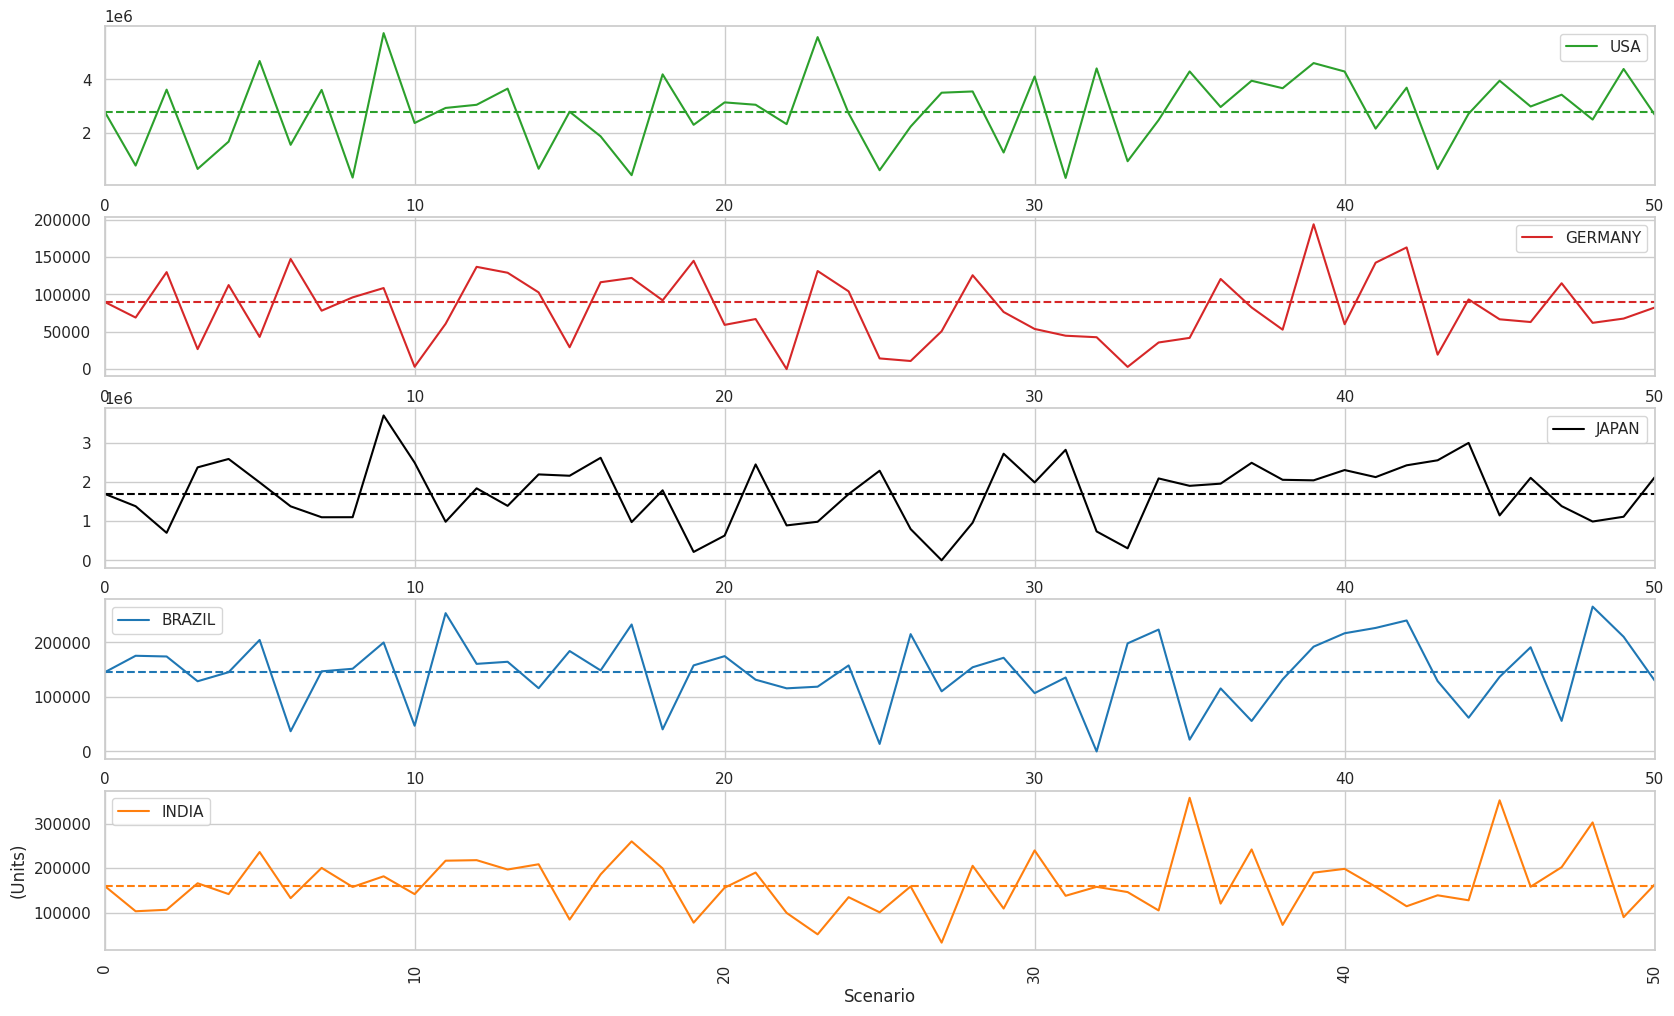

In [ ]:
# Plot
figure, axes = plt.subplots(len(markets), 1)
colors = ['tab:green', 'tab:red', 'black', 'tab:blue', 'tab:orange']
for i in range(len(markets)):
    df_demand.plot(figsize=(20, 12), xlim=[0,N], x='scenario', y=markets[i], ax=axes[i], grid = True, color = colors[i])
    axes[i].axhline(df_demand[markets[i]].values[0], color=colors[i], linestyle="--")
plt.xlabel('Scenario')
plt.ylabel('(Units)')
plt.xticks(rotation=90)
plt.show()

#### Calculation: Initial Scenario

In [ ]:
# Record results per scenario
list_scenario, list_status, list_results, list_totald, list_fixcost, list_varcost = [], [], [], [], [], []
# Initial Scenario
status_out, objective_out, y, x, fix, var = optimization_model(fixed_costs, var_cost, demand, 'Demand', cap)

# Add results
list_scenario.append('INITIAL')
total_demand = demand['Demand'].sum()
list_totald.append(total_demand)
list_status.append(status_out)
list_results.append(objective_out)
list_fixcost.append(fix)
list_varcost.append(var)
# Dataframe to record the solutions
df_bool = pd.DataFrame(data = [y[plant_name[i]].varValue for i in range(len(plant_name))], index = [i + '-' + s for s in size for i in loc],
                        columns = ['INITIAL'])
df_bool.head()

/usr/local/lib/python3.11/dist-packages/pulp/pulp.py:1424: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


,INITIAL
USA-LOW,0.0
GERMANY-LOW,0.0
JAPAN-LOW,0.0
BRAZIL-LOW,0.0
INDIA-LOW,1.0


In [ ]:
# Simulate all scenarios
demand_var = df_demand.drop(['scenario'], axis = 1).T

# Loop
for i in range(1, 50): # 0 is the initial scenario
    # Calculations
    status_out, objective_out, y, x, fix, var = optimization_model(fixed_costs, var_cost, demand_var, i, cap)

    # Append results
    list_status.append(status_out)
    list_results.append(objective_out)
    df_bool[i] = [y[plant_name[i]].varValue for i in range(len(plant_name))]
    list_fixcost.append(fix)
    list_varcost.append(var)
    total_demand = demand_var[i].sum()
    list_totald.append(total_demand)
    list_scenario.append(i)
# Final Results
# Boolean
df_bool = df_bool.astype(int)
df_bool.to_excel('boolean-{}PC.xlsx'.format(int(CV * 100)))
# Other Results
df_bool.head()

/usr/local/lib/python3.11/dist-packages/pulp/pulp.py:1424: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
/usr/local/lib/python3.11/dist-packages/pulp/pulp.py:1424: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
/usr/local/lib/python3.11/dist-packages/pulp/pulp.py:1424: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
/usr/local/lib/python3.11/dist-packages/pulp/pulp.py:1424: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
/usr/local/lib/python3.11/dist-packages/pulp/pulp.py:1424: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '

,INITIAL,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
USA-LOW,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GERMANY-LOW,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0
JAPAN-LOW,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0
BRAZIL-LOW,0,0,0,0,1,0,1,0,1,1,0,1,1,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1,1,1,1,1,0,1,1,0,1,1,1,0,1,1
INDIA-LOW,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1


---

### Final Plot
#### Boolean Alone

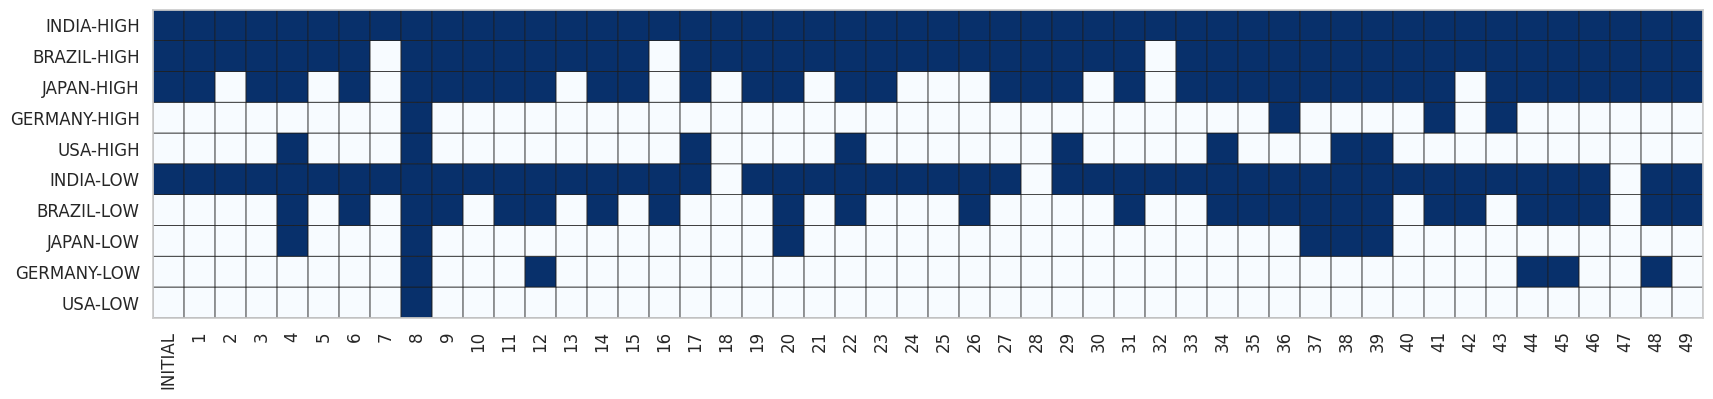

In [ ]:
# Plot the Grid
plt.figure(figsize = (20,4))
plt.pcolor( df_bool, cmap = 'Blues', edgecolors='k', linewidths=0.5)   #
plt.xticks([i + 0.5 for i in range(df_bool.shape[1])], df_bool.columns, rotation = 90, fontsize=12)
plt.yticks([i + 0.5 for i in range(df_bool.shape[0])], df_bool.index, fontsize=12)
plt.show()

#### Add Demand

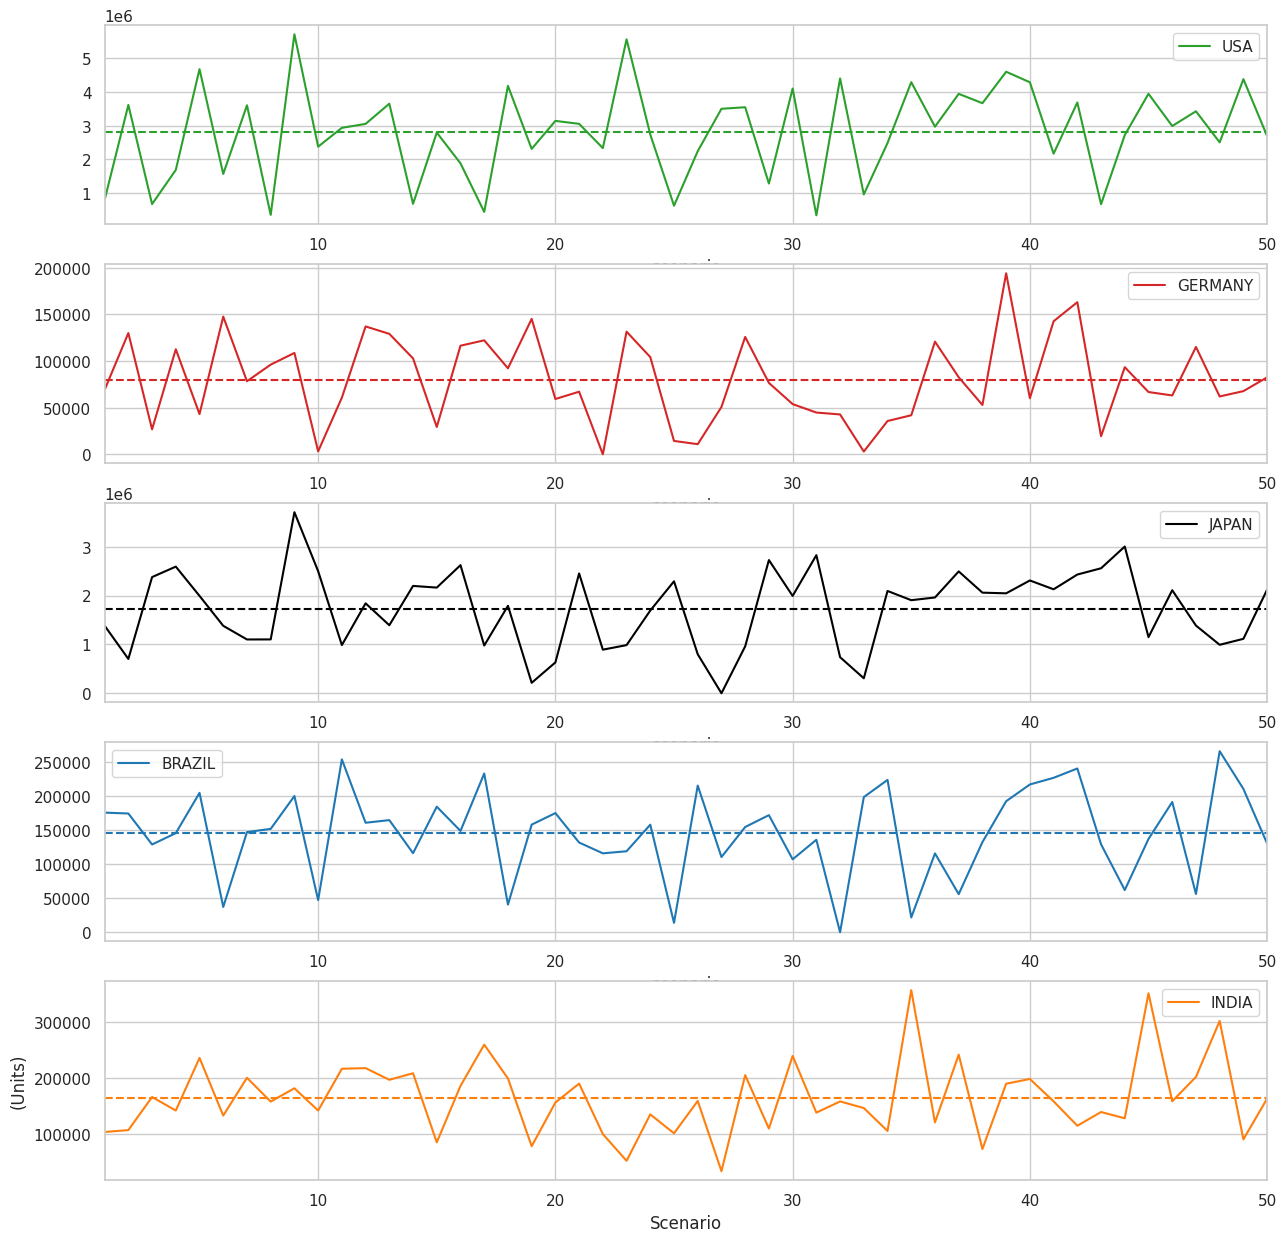

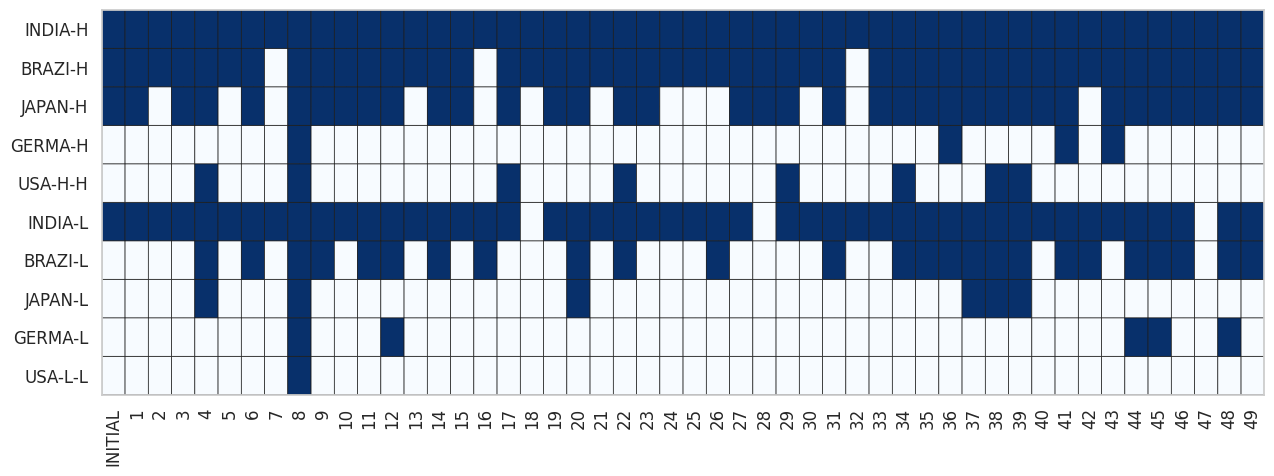

In [ ]:
# Plot
figure, axes = plt.subplots(len(markets), 1)
colors = ['tab:green', 'tab:red', 'black', 'tab:blue', 'tab:orange']
for i in range(len(markets)):
    df_demand.plot(figsize=(15, 15), xlim=[1,N], x='scenario', y=markets[i], ax=axes[i], grid = True, color = colors[i])
    axes[i].axhline(df_demand[markets[i]].mean(), color=colors[i], linestyle="--")
plt.xlabel('Scenario')
plt.ylabel('(Units)')

# add the scenario plot
plt.figure(figsize=(15, 5))
plt.pcolor(df_bool, cmap = 'Blues', edgecolors='k', linewidths=0.5)   #
plt.xticks([i + 0.5 for i in range(df_bool.shape[1])], df_bool.columns, rotation = 90, fontsize=12)
plt.yticks([i + 0.5 for i in range(df_bool.shape[0])], [d[0:5]+ '-H' * ('HIGH' in d) + '-L' * ('LOW' in d) for d in df_bool.index], fontsize=12)
plt.xticks(rotation=90)
plt.show()

---

## Find the optimal Solution
#### Unique Combinations

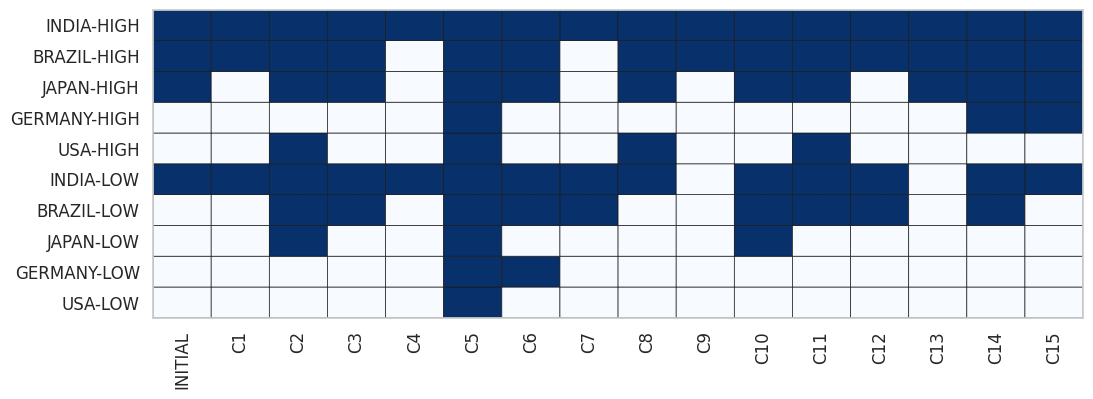

In [ ]:
# Unique combinations
df_unique = df_bool.T.drop_duplicates().T
df_unique.columns = ['INITIAL'] + ['C' + str(i) for i in range(1, len(df_unique.columns))]
# Plot the Grid
plt.figure(figsize = (12,4))
plt.pcolor( df_unique, cmap = 'Blues', edgecolors='k', linewidths=0.5)   #
plt.xticks([i + 0.5 for i in range(df_unique.shape[1])], df_unique.columns, rotation = 90, fontsize=12)
plt.yticks([i + 0.5 for i in range(df_unique.shape[0])], df_unique.index, fontsize=12)
plt.show()

#### Number of Combinations

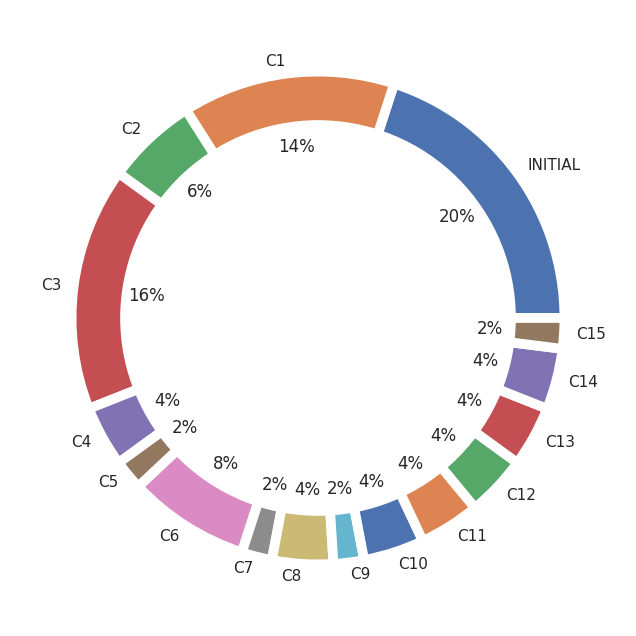

In [ ]:
# Number of columns
COL_NAME, COL_NUMBER = [], []
for col1 in df_unique.columns:
    count = 0
    COL_NAME.append(col1)
    for col2 in df_bool.columns:
        if (df_bool[col2]!=df_unique[col1]).sum()==0:
            count += 1
    COL_NUMBER.append(count)
df_comb = pd.DataFrame({'column':COL_NAME, 'count':COL_NUMBER}).set_index('column')

my_circle = plt.Circle( (0,0), 0.8, color='white')
df_comb.plot.pie(figsize=(8, 8), x='column', y='count', legend= False, pctdistance=0.7,
                                          autopct='%1.0f%%', labeldistance=1.05,
                                          wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })
plt.xlabel('Business Vertical')
# plt.title('{:.2f} M€ Budget Applications in 9 Vertical Markets'.format(df_p['TOTAL'].sum()/1e6))
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('off')
plt.show()

/usr/local/lib/python3.11/dist-packages/pulp/pulp.py:1424: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
/usr/local/lib/python3.11/dist-packages/pulp/pulp.py:1424: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
/usr/local/lib/python3.11/dist-packages/pulp/pulp.py:1424: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
/usr/local/lib/python3.11/dist-packages/pulp/pulp.py:1424: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
/usr/local/lib/python3.11/dist-packages/pulp/pulp.py:1424: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '

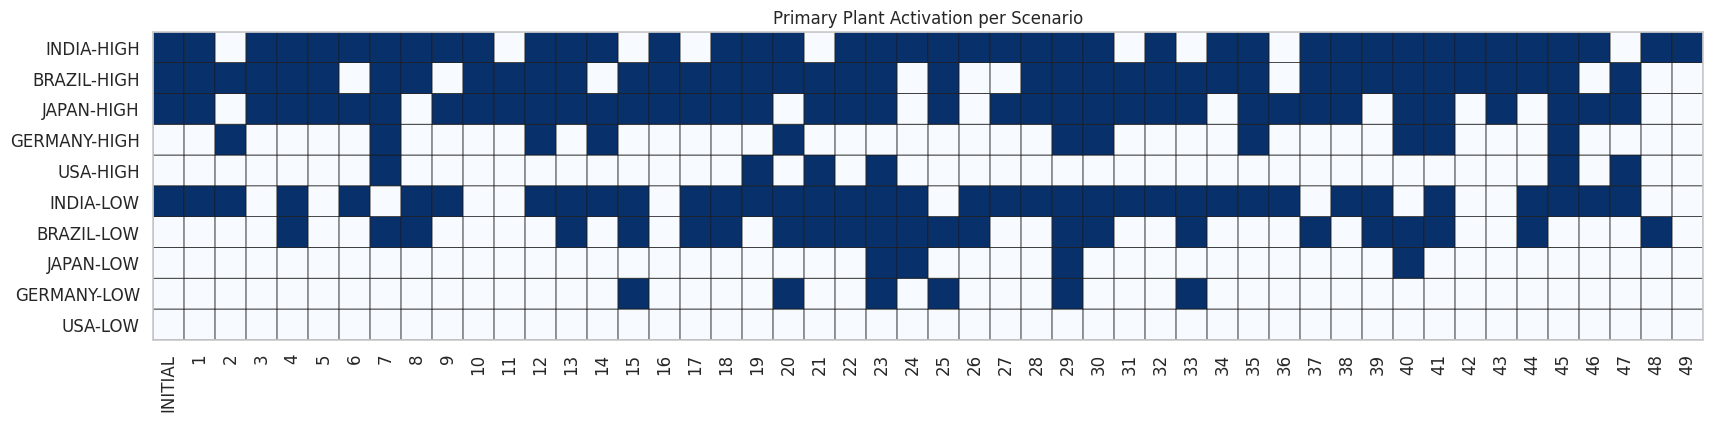

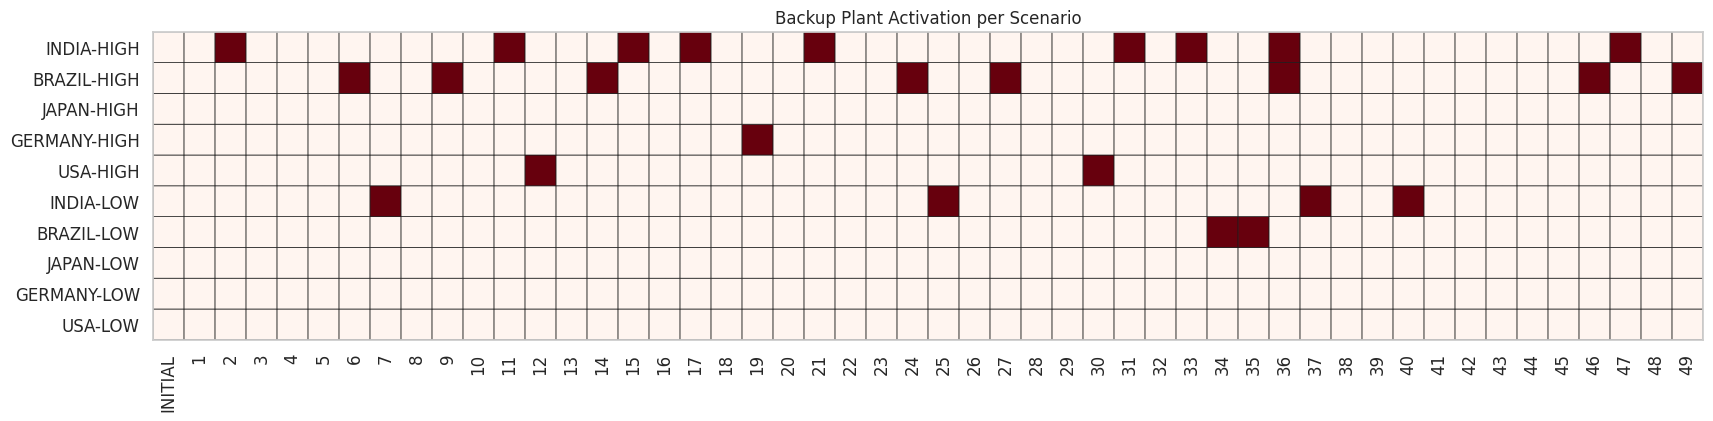

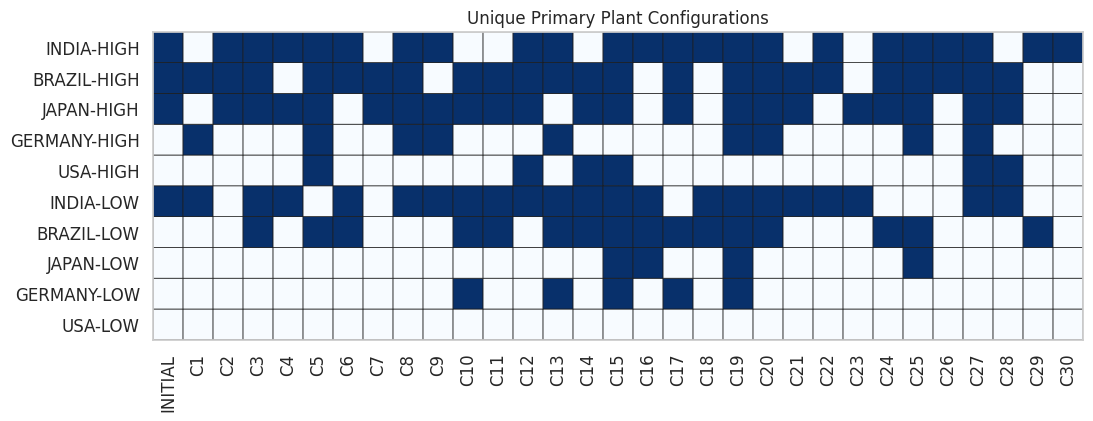

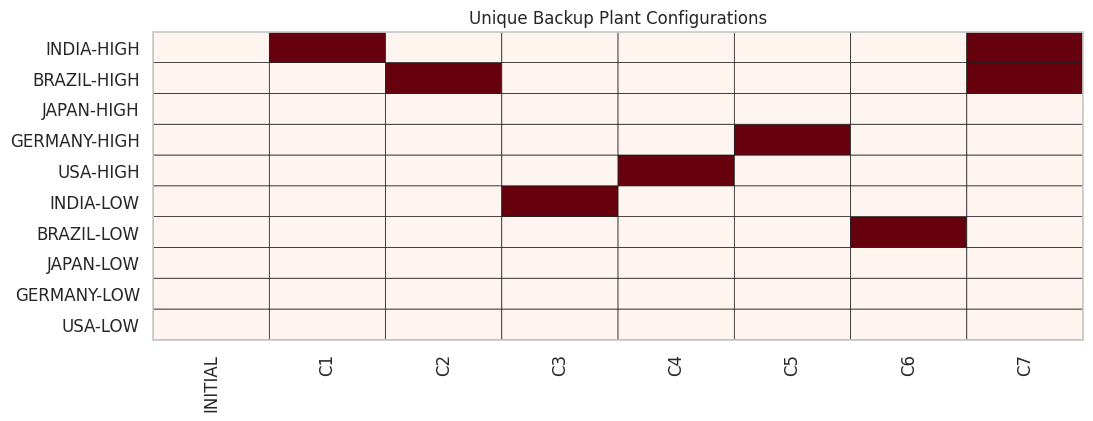

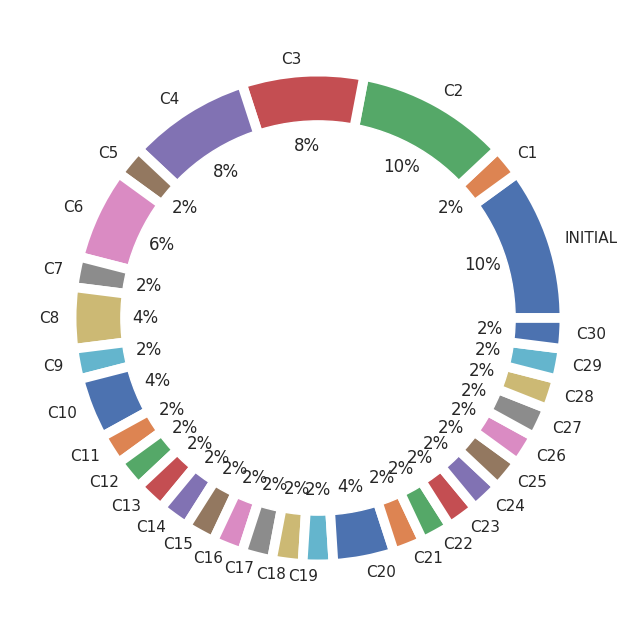

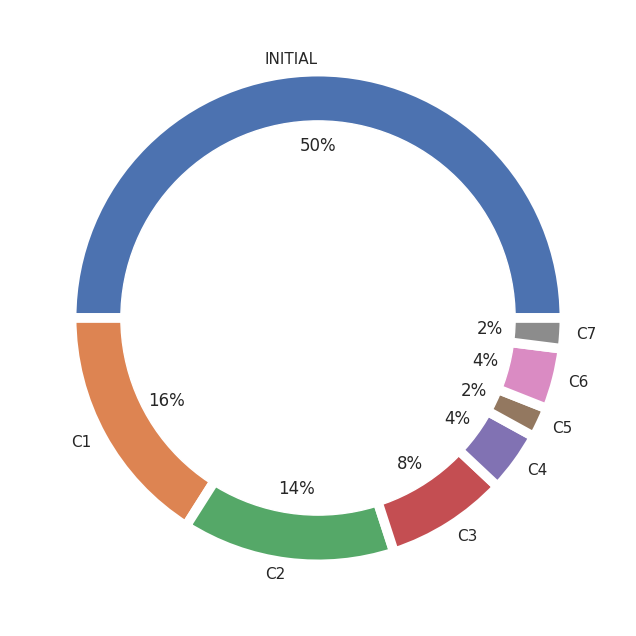

In [ ]:
import pulp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def optimization_model_with_backup(fixed_costs, var_cost, demand, demand_col, cap, failed_plants=None):
    '''Build the optimization model with backup switch based on input parameters'''
    # Define Decision Variables
    loc = ['USA', 'GERMANY', 'JAPAN', 'BRAZIL', 'INDIA']
    size = ['LOW', 'HIGH']
    plant_name = [(i,s) for s in size for i in loc]
    prod_name = [(i,j) for i in loc for j in loc]

    # Initialize Class
    model = pulp.LpProblem("Capacitated Plant Location Model with Backup", pulp.LpMinimize)

    # Create Decision Variables
    x = pulp.LpVariable.dicts("production_", prod_name, lowBound=0, upBound=None, cat='Continuous')
    y = pulp.LpVariable.dicts("plant_", plant_name, cat='Binary')
    y_backup = pulp.LpVariable.dicts("backup_plant_", plant_name, cat='Binary')

    # Define Objective Function
    backup_cost_factor = 1.5
    model += (
        pulp.lpSum([fixed_costs.loc[i,s] * y[(i,s)] * 1000 for s in size for i in loc]) +
        pulp.lpSum([fixed_costs.loc[i,s] * backup_cost_factor * y_backup[(i,s)] * 1000 for s in size for i in loc]) +
        pulp.lpSum([var_cost.loc[i,j] * x[(i,j)] for i in loc for j in loc])
    )

    # Demand constraint
    for j in loc:
        model += pulp.lpSum([x[(i, j)] for i in loc]) == demand.loc[j, demand_col]

    # Capacity constraint with backup
    for i in loc:
        total_production = pulp.lpSum([x[(i, j)] for j in loc])
        total_capacity = pulp.lpSum([cap.loc[i,s] * y[(i,s)] * 1000 for s in size]) + \
                         pulp.lpSum([cap.loc[i,s] * y_backup[(i,s)] * 1000 for s in size])
        model += total_production <= total_capacity

    # Backup activation constraint
    for i in loc:
        for s in size:
            model += y[(i,s)] + y_backup[(i,s)] <= 1

    # Forced Plant Failures
    if failed_plants is not None:
        for (i, s) in failed_plants:
            model += y[(i,s)] == 0

    # Solve Model
    model.solve()

    # Results
    status_out = pulp.LpStatus[model.status]
    objective_out = pulp.value(model.objective)
    fix = sum([fixed_costs.loc[i,s] * y[(i,s)].varValue * 1000 for s in size for i in loc])
    fix_backup = sum([fixed_costs.loc[i,s] * backup_cost_factor * y_backup[(i,s)].varValue * 1000 for s in size for i in loc])
    var = sum([var_cost.loc[i,j] * x[(i,j)].varValue for i in loc for j in loc])
    return status_out, objective_out, y, y_backup, x, fix, fix_backup, var

# SIMULATION PART

# Settings
N = 50  # Number of scenarios
CV = 0.5  # Coefficient of variation for demand randomness

# Assume fixed_costs, var_cost, cap, demand are loaded here
# (You need to define or import them before running)

# Generate demand scenarios
df_demand = pd.DataFrame({'scenario': np.array(range(1, N + 1))})
data = demand.reset_index()
markets = data['(Units/month)'].values
for col, value in zip(markets, data['Demand'].values):
    sigma = CV * value
    df_demand[col] = np.random.normal(value, sigma, N)
    df_demand[col] = df_demand[col].apply(lambda t: t if t >= 0 else 0)

# Add Initial Scenario
COLS = ['scenario'] + list(demand.index)
VALS = [0] + list(demand['Demand'].values)
df_init = pd.DataFrame(dict(zip(COLS, VALS)), index=[0])
df_demand = pd.concat([df_init, df_demand])
df_demand.to_excel('df_demand-{}PC.xlsx'.format(int(CV * 100)))

# Prepare recording structures
list_scenario, list_status, list_results, list_totald, list_fixcost, list_fixcost_backup, list_varcost = [], [], [], [], [], [], []
plant_name = [(i,s) for s in ['LOW', 'HIGH'] for i in ['USA', 'GERMANY', 'JAPAN', 'BRAZIL', 'INDIA']]

# Initial Scenario
status_out, objective_out, y, y_backup, x, fix, fix_backup, var = optimization_model_with_backup(
    fixed_costs, var_cost, demand, 'Demand', cap, failed_plants=None
)

# Store initial results
list_scenario.append('INITIAL')
list_totald.append(demand['Demand'].sum())
list_status.append(status_out)
list_results.append(objective_out)
list_fixcost.append(fix)
list_fixcost_backup.append(fix_backup)
list_varcost.append(var)

df_bool = pd.DataFrame(data=[y[plant_name[i]].varValue for i in range(len(plant_name))],
                       index=[i + '-' + s for s in ['LOW', 'HIGH'] for i in ['USA', 'GERMANY', 'JAPAN', 'BRAZIL', 'INDIA']],
                       columns=['INITIAL'])
df_bool_backup = pd.DataFrame(data=[y_backup[plant_name[i]].varValue for i in range(len(plant_name))],
                              index=[i + '-' + s for s in ['LOW', 'HIGH'] for i in ['USA', 'GERMANY', 'JAPAN', 'BRAZIL', 'INDIA']],
                              columns=['INITIAL'])

# Simulate all scenarios
demand_var = df_demand.drop(['scenario'], axis=1).T

for i in range(1, N):
    # Randomly fail plants
    n_failures = np.random.choice([1, 2], p=[0.7, 0.3])
    failed_plants = []
    for _ in range(n_failures):
        loc_fail = np.random.choice(['USA', 'GERMANY', 'JAPAN', 'BRAZIL', 'INDIA'])
        size_fail = np.random.choice(['LOW', 'HIGH'])
        failed_plants.append((loc_fail, size_fail))

    # Solve
    status_out, objective_out, y, y_backup, x, fix, fix_backup, var = optimization_model_with_backup(
        fixed_costs, var_cost, demand_var, i, cap, failed_plants=failed_plants
    )

    # Save results
    list_scenario.append(i)
    list_totald.append(demand_var[i].sum())
    list_status.append(status_out)
    list_results.append(objective_out)
    list_fixcost.append(fix)
    list_fixcost_backup.append(fix_backup)
    list_varcost.append(var)

    df_bool[i] = [y[plant_name[j]].varValue for j in range(len(plant_name))]
    df_bool_backup[i] = [y_backup[plant_name[j]].varValue for j in range(len(plant_name))]

# Save Outputs
df_bool = df_bool.astype(int)
df_bool_backup = df_bool_backup.astype(int)
df_bool.to_excel('boolean-{}PC.xlsx'.format(int(CV * 100)))
df_bool_backup.to_excel('boolean_backup-{}PC.xlsx'.format(int(CV * 100)))

# PLOTTING

# Primary Plants
plt.figure(figsize=(20, 4))
plt.pcolor(df_bool, cmap='Blues', edgecolors='k', linewidths=0.5)
plt.xticks([i + 0.5 for i in range(df_bool.shape[1])], df_bool.columns, rotation=90, fontsize=12)
plt.yticks([i + 0.5 for i in range(df_bool.shape[0])], df_bool.index, fontsize=12)
plt.title('Primary Plant Activation per Scenario')
plt.show()

# Backup Plants
plt.figure(figsize=(20, 4))
plt.pcolor(df_bool_backup, cmap='Reds', edgecolors='k', linewidths=0.5)
plt.xticks([i + 0.5 for i in range(df_bool_backup.shape[1])], df_bool_backup.columns, rotation=90, fontsize=12)
plt.yticks([i + 0.5 for i in range(df_bool_backup.shape[0])], df_bool_backup.index, fontsize=12)
plt.title('Backup Plant Activation per Scenario')
plt.show()

# Unique Configurations
df_unique = df_bool.T.drop_duplicates().T
df_unique.columns = ['INITIAL'] + ['C' + str(i) for i in range(1, len(df_unique.columns))]
df_unique_backup = df_bool_backup.T.drop_duplicates().T
df_unique_backup.columns = ['INITIAL'] + ['C' + str(i) for i in range(1, len(df_unique_backup.columns))]

# Primary Plants - Unique
plt.figure(figsize=(12, 4))
plt.pcolor(df_unique, cmap='Blues', edgecolors='k', linewidths=0.5)
plt.xticks([i + 0.5 for i in range(df_unique.shape[1])], df_unique.columns, rotation=90, fontsize=12)
plt.yticks([i + 0.5 for i in range(df_unique.shape[0])], df_unique.index, fontsize=12)
plt.title('Unique Primary Plant Configurations')
plt.show()

# Backup Plants - Unique
plt.figure(figsize=(12, 4))
plt.pcolor(df_unique_backup, cmap='Reds', edgecolors='k', linewidths=0.5)
plt.xticks([i + 0.5 for i in range(df_unique_backup.shape[1])], df_unique_backup.columns, rotation=90, fontsize=12)
plt.yticks([i + 0.5 for i in range(df_unique_backup.shape[0])], df_unique_backup.index, fontsize=12)
plt.title('Unique Backup Plant Configurations')
plt.show()

# Pie Chart for Primary
COL_NAME, COL_NUMBER = [], []
for col1 in df_unique.columns:
    count = 0
    COL_NAME.append(col1)
    for col2 in df_bool.columns:
        if (df_bool[col2] != df_unique[col1]).sum() == 0:
            count += 1
    COL_NUMBER.append(count)

df_comb = pd.DataFrame({'column': COL_NAME, 'count': COL_NUMBER}).set_index('column')
my_circle = plt.Circle((0, 0), 0.8, color='white')
df_comb.plot.pie(figsize=(8, 8), y='count', legend=False, pctdistance=0.7,
                 autopct='%1.0f%%', labeldistance=1.05,
                 wedgeprops={'linewidth': 7, 'edgecolor': 'white'})
plt.xlabel('Primary Plant Combinations')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('off')
plt.show()

# Pie Chart for Backup
COL_NAME, COL_NUMBER = [], []
for col1 in df_unique_backup.columns:
    count = 0
    COL_NAME.append(col1)
    for col2 in df_bool_backup.columns:
        if (df_bool_backup[col2] != df_unique_backup[col1]).sum() == 0:
            count += 1
    COL_NUMBER.append(count)

df_comb_backup = pd.DataFrame({'column': COL_NAME, 'count': COL_NUMBER}).set_index('column')
my_circle = plt.Circle((0, 0), 0.8, color='white')
df_comb_backup.plot.pie(figsize=(8, 8), y='count', legend=False, pctdistance=0.7,
                        autopct='%1.0f%%', labeldistance=1.05,
                        wedgeprops={'linewidth': 7, 'edgecolor': 'white'})
plt.xlabel('Backup Plant Combinations')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('off')
plt.show()


/usr/local/lib/python3.11/dist-packages/pulp/pulp.py:1424: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
/usr/local/lib/python3.11/dist-packages/pulp/pulp.py:1424: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
/usr/local/lib/python3.11/dist-packages/pulp/pulp.py:1424: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
/usr/local/lib/python3.11/dist-packages/pulp/pulp.py:1424: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
/usr/local/lib/python3.11/dist-packages/pulp/pulp.py:1424: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '

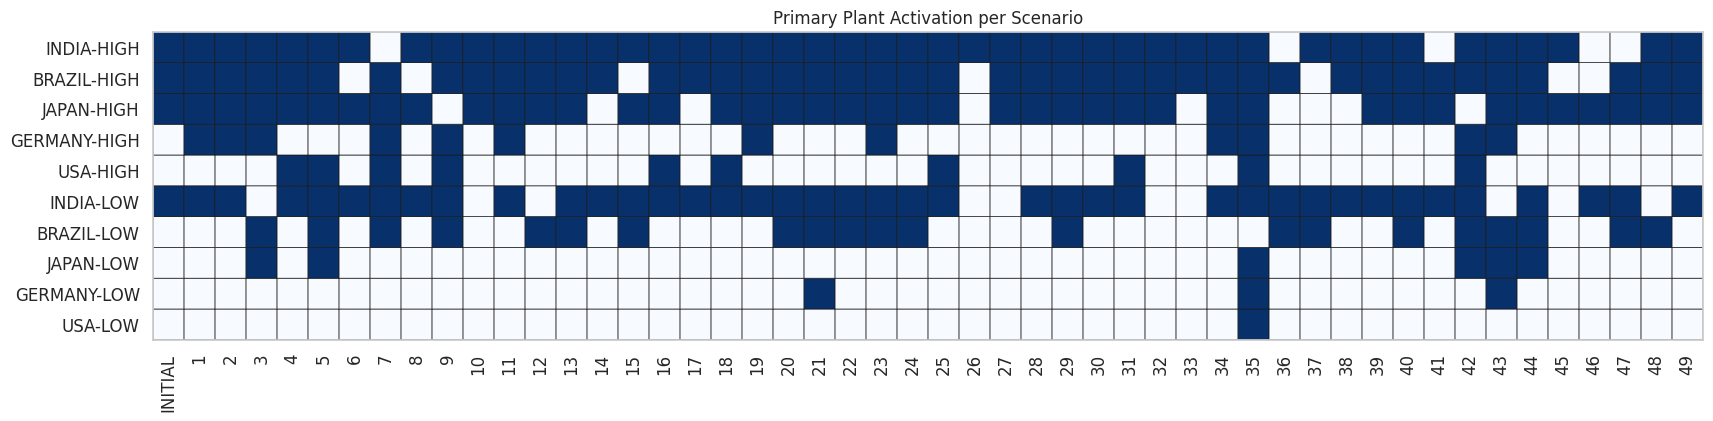

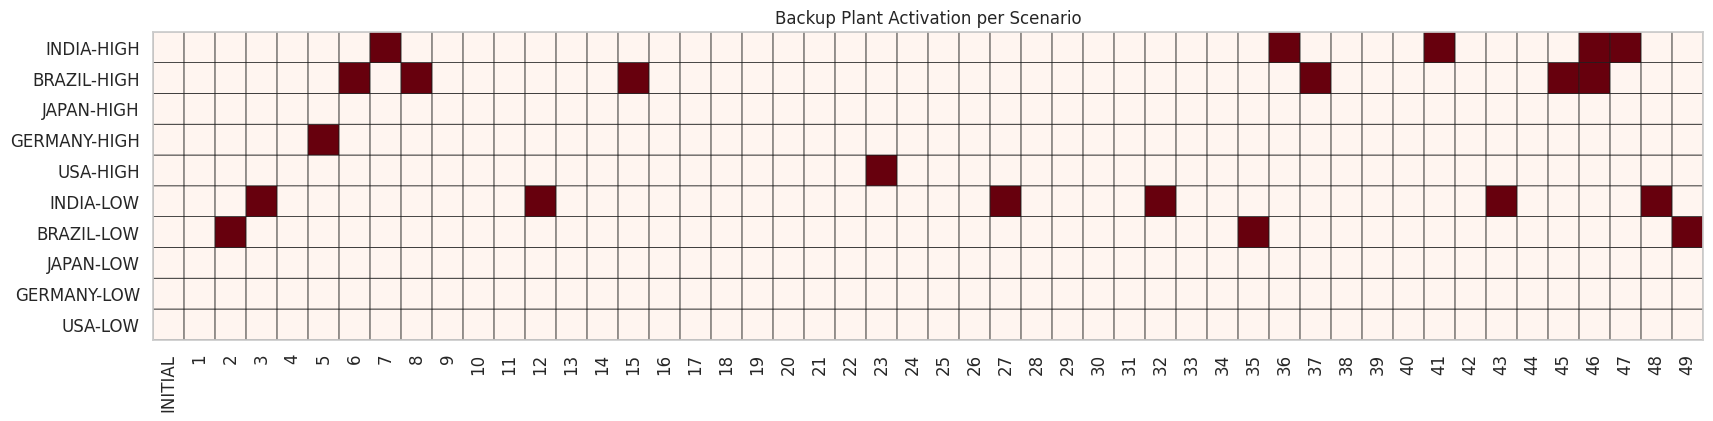

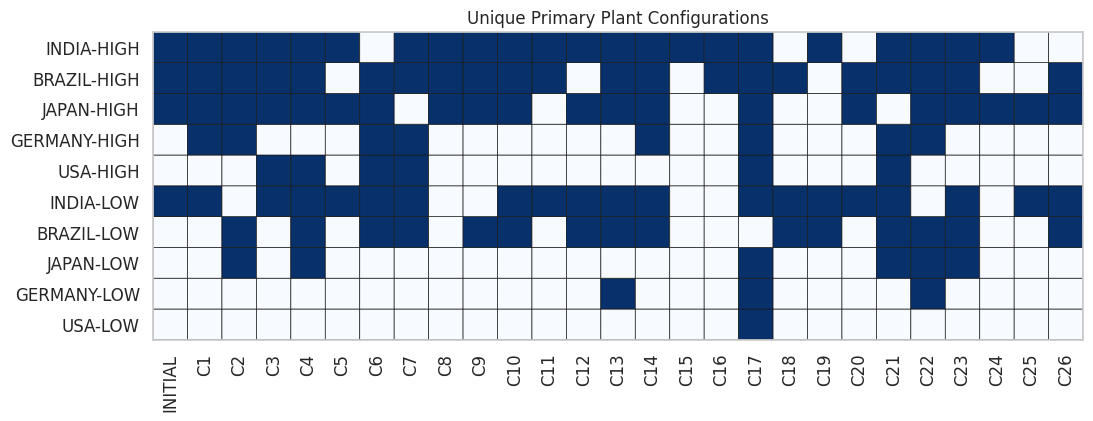

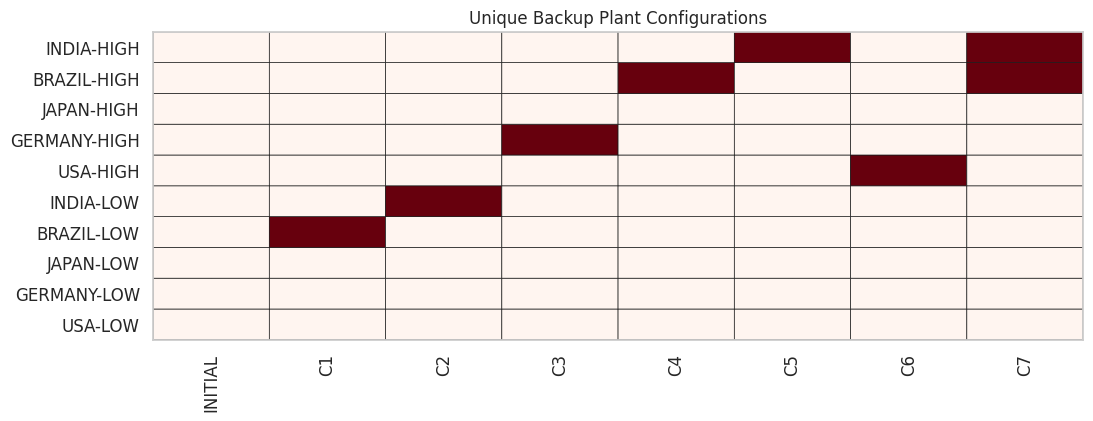

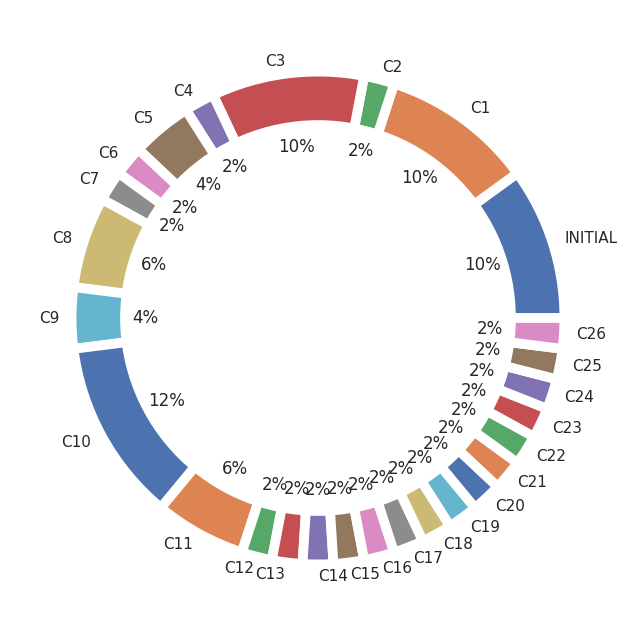

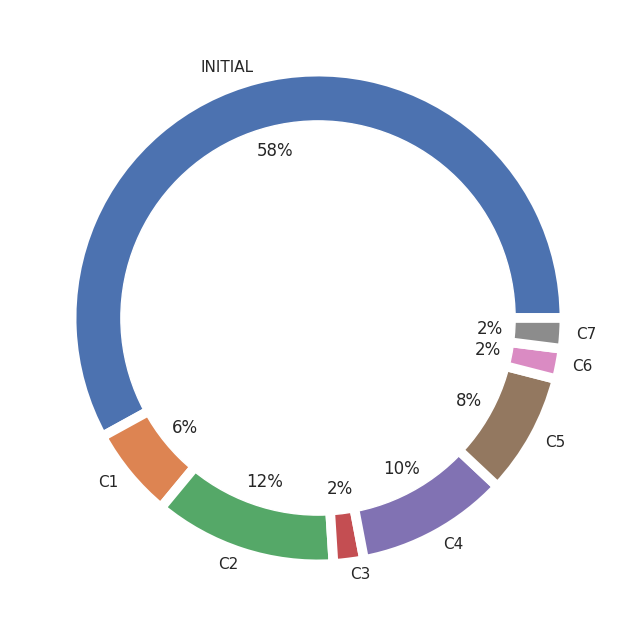

In [ ]:
import pulp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ======== Optimization Function ========
def optimization_model_with_backup(fixed_costs, var_cost, demand, demand_col, cap, failed_plants=None):
    loc = ['USA', 'GERMANY', 'JAPAN', 'BRAZIL', 'INDIA']
    size = ['LOW', 'HIGH']
    plant_name = [(i,s) for s in size for i in loc]
    prod_name = [(i,j) for i in loc for j in loc]

    model = pulp.LpProblem("Capacitated Plant Location Model with Backup", pulp.LpMinimize)

    x = pulp.LpVariable.dicts("production_", prod_name, lowBound=0, upBound=None, cat='Continuous')
    y = pulp.LpVariable.dicts("plant_", plant_name, cat='Binary')
    y_backup = pulp.LpVariable.dicts("backup_plant_", plant_name, cat='Binary')

    backup_cost_factor = 1.5
    model += (
        pulp.lpSum([fixed_costs.loc[i,s] * y[(i,s)] * 1000 for s in size for i in loc]) +
        pulp.lpSum([fixed_costs.loc[i,s] * backup_cost_factor * y_backup[(i,s)] * 1000 for s in size for i in loc]) +
        pulp.lpSum([var_cost.loc[i,j] * x[(i,j)] for i in loc for j in loc])
    )

    for j in loc:
        model += pulp.lpSum([x[(i, j)] for i in loc]) == demand.loc[j, demand_col]

    for i in loc:
        total_production = pulp.lpSum([x[(i, j)] for j in loc])
        total_capacity = pulp.lpSum([cap.loc[i,s] * y[(i,s)] * 1000 for s in size]) + \
                         pulp.lpSum([cap.loc[i,s] * y_backup[(i,s)] * 1000 for s in size])
        model += total_production <= total_capacity
    for i in loc:
        for s in size:
            model += y[(i,s)] + y_backup[(i,s)] <= 1

    if failed_plants is not None:
        for (i, s) in failed_plants:
            model += y[(i,s)] == 0

    model.solve()

    status_out = pulp.LpStatus[model.status]
    objective_out = pulp.value(model.objective)
    fix = sum([fixed_costs.loc[i,s] * y[(i,s)].varValue * 1000 for s in size for i in loc])
    fix_backup = sum([fixed_costs.loc[i,s] * 1.5 * y_backup[(i,s)].varValue * 1000 for s in size for i in loc])
    var = sum([var_cost.loc[i,j] * x[(i,j)].varValue for i in loc for j in loc])

    return status_out, objective_out, y, y_backup, x, fix, fix_backup, var

# ======== Simulation Settings ========
N = 50
CV = 0.5
loc = ['USA', 'GERMANY', 'JAPAN', 'BRAZIL', 'INDIA']
size = ['LOW', 'HIGH']
plant_name = [(i,s) for s in size for i in loc]

# ======== Assume fixed_costs, var_cost, cap, demand are already loaded ========

# ======== Generate Demand Scenarios ========
df_demand = pd.DataFrame({'scenario': np.array(range(1, N + 1))})
data = demand.reset_index()
markets = data['(Units/month)'].values
for col, value in zip(markets, data['Demand'].values):
    sigma = CV * value
    df_demand[col] = np.random.normal(value, sigma, N)
    df_demand[col] = df_demand[col].apply(lambda t: t if t >= 0 else 0)

COLS = ['scenario'] + list(demand.index)
VALS = [0] + list(demand['Demand'].values)
df_init = pd.DataFrame(dict(zip(COLS, VALS)), index=[0])
df_demand = pd.concat([df_init, df_demand])
df_demand.to_excel('df_demand-{}PC.xlsx'.format(int(CV * 100)))

# ======== Initialize Storage ========
list_scenario, list_status, list_results, list_totald, list_fixcost, list_fixcost_backup, list_varcost = [], [], [], [], [], [], []

# Initial Scenario
status_out, objective_out, y, y_backup, x, fix, fix_backup, var = optimization_model_with_backup(
    fixed_costs, var_cost, demand, 'Demand', cap, failed_plants=None
)

list_scenario.append('INITIAL')
list_totald.append(demand['Demand'].sum())
list_status.append(status_out)
list_results.append(objective_out)
list_fixcost.append(fix)
list_fixcost_backup.append(fix_backup)
list_varcost.append(var)


df_bool = pd.DataFrame(data=[y[plant_name[i]].varValue for i in range(len(plant_name))],
                       index=[i + '-' + s for s in ['LOW', 'HIGH'] for i in ['USA', 'GERMANY', 'JAPAN', 'BRAZIL', 'INDIA']],
                       columns=['INITIAL'])
df_bool_backup = pd.DataFrame(data=[y_backup[plant_name[i]].varValue for i in range(len(plant_name))],
                              index=[i + '-' + s for s in ['LOW', 'HIGH'] for i in ['USA', 'GERMANY', 'JAPAN', 'BRAZIL', 'INDIA']],
                              columns=['INITIAL'])

# ======== Run Simulation for all Scenarios ========
demand_var = df_demand.drop(['scenario'], axis=1).T
for i in range(1, N):
    n_failures = np.random.choice([1, 2], p=[0.7, 0.3])
    failed_plants = [(np.random.choice(loc), np.random.choice(size)) for _ in range(n_failures)]

    status_out, objective_out, y, y_backup, x, fix, fix_backup, var = optimization_model_with_backup(
        fixed_costs, var_cost, demand_var, i, cap, failed_plants=failed_plants
    )

    list_scenario.append(i)
    list_totald.append(demand_var[i].sum())
    list_status.append(status_out)
    list_results.append(objective_out)
    list_fixcost.append(fix)
    list_fixcost_backup.append(fix_backup)
    list_varcost.append(var)

    df_bool[i] = [y[plant_name[j]].varValue for j in range(len(plant_name))]
    df_bool_backup[i] = [y_backup[plant_name[j]].varValue for j in range(len(plant_name))]

# Save Outputs
df_bool = df_bool.astype(int)
df_bool_backup = df_bool_backup.astype(int)
df_bool.to_excel('boolean-{}PC.xlsx'.format(int(CV * 100)))
df_bool_backup.to_excel('boolean_backup-{}PC.xlsx'.format(int(CV * 100)))

# ======== PLOTS ========

# --- Primary Plants Activation ---
plt.figure(figsize=(20, 4))
plt.pcolor(df_bool, cmap='Blues', edgecolors='k', linewidths=0.5)
plt.xticks([i + 0.5 for i in range(df_bool.shape[1])], df_bool.columns, rotation=90, fontsize=12)
plt.yticks([i + 0.5 for i in range(df_bool.shape[0])], df_bool.index, fontsize=12)
plt.title('Primary Plant Activation per Scenario')
plt.show()

# --- Backup Plants Activation ---
plt.figure(figsize=(20, 4))
plt.pcolor(df_bool_backup, cmap='Reds', edgecolors='k', linewidths=0.5)
plt.xticks([i + 0.5 for i in range(df_bool_backup.shape[1])], df_bool_backup.columns, rotation=90, fontsize=12)
plt.yticks([i + 0.5 for i in range(df_bool_backup.shape[0])], df_bool_backup.index, fontsize=12)
plt.title('Backup Plant Activation per Scenario')
plt.show()

# --- Unique Configurations ---
df_unique = df_bool.T.drop_duplicates().T
df_unique.columns = ['INITIAL'] + ['C' + str(i) for i in range(1, len(df_unique.columns))]

df_unique_backup = df_bool_backup.T.drop_duplicates().T
df_unique_backup.columns = ['INITIAL'] + ['C' + str(i) for i in range(1, len(df_unique_backup.columns))]

plt.figure(figsize=(12, 4))
plt.pcolor(df_unique, cmap='Blues', edgecolors='k', linewidths=0.5)
plt.xticks([i + 0.5 for i in range(df_unique.shape[1])], df_unique.columns, rotation=90, fontsize=12)
plt.yticks([i + 0.5 for i in range(df_unique.shape[0])], df_unique.index, fontsize=12)
plt.title('Unique Primary Plant Configurations')
plt.show()

plt.figure(figsize=(12, 4))
plt.pcolor(df_unique_backup, cmap='Reds', edgecolors='k', linewidths=0.5)
plt.xticks([i + 0.5 for i in range(df_unique_backup.shape[1])], df_unique_backup.columns, rotation=90, fontsize=12)
plt.yticks([i + 0.5 for i in range(df_unique_backup.shape[0])], df_unique_backup.index, fontsize=12)
plt.title('Unique Backup Plant Configurations')
plt.show()

# --- Pie Charts ---
def pie_chart(df_bool, df_unique, title):
    COL_NAME, COL_NUMBER = [], []
    for col1 in df_unique.columns:
        count = sum((df_bool[col2] == df_unique[col1]).all() for col2 in df_bool.columns)
        COL_NAME.append(col1)
        COL_NUMBER.append(count)

    df_comb = pd.DataFrame({'column': COL_NAME, 'count': COL_NUMBER}).set_index('column')
    my_circle = plt.Circle((0, 0), 0.8, color='white')
    df_comb.plot.pie(figsize=(8, 8), y='count', legend=False, pctdistance=0.7,
                     autopct='%1.0f%%', labeldistance=1.05,
                     wedgeprops={'linewidth': 7, 'edgecolor': 'white'})
    plt.xlabel(title)
    p = plt.gcf()
    p.gca().add_artist(my_circle)
    plt.axis('off')
    plt.show()

pie_chart(df_bool, df_unique, 'Primary Plant Combinations')
pie_chart(df_bool_backup, df_unique_backup, 'Backup Plant Combinations')


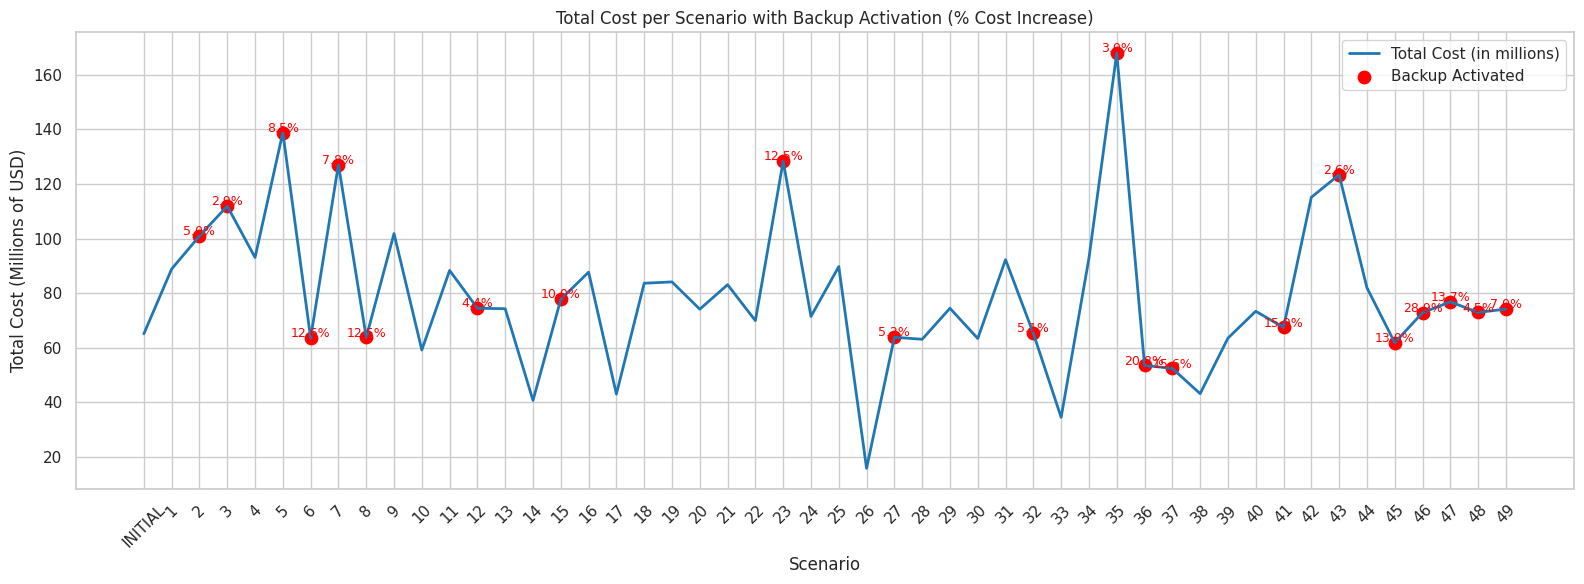

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert lists to arrays for easier indexing
scenarios = np.arange(len(list_results))  # Will be 51 if N=50 + 1 INITIAL
total_costs = np.array(list_results)
backup_costs = np.array(list_fixcost_backup)

# Convert costs to millions
total_costs_millions = total_costs / 1_000_000
backup_costs_millions = backup_costs / 1_000_000
base_costs_millions = total_costs_millions - backup_costs_millions

# Indices where backup was used
backup_indices = np.where(backup_costs_millions > 0)[0]

# Plotting
plt.figure(figsize=(16, 6))
plt.plot(scenarios, total_costs_millions, label='Total Cost (in millions)', color='tab:blue', linewidth=2)
plt.scatter(backup_indices, total_costs_millions[backup_indices], color='red', s=80, label='Backup Activated')

# Annotate percentage increase
for idx in backup_indices:
    pct_increase = (backup_costs_millions[idx] / base_costs_millions[idx]) * 100 if base_costs_millions[idx] != 0 else 0
    plt.text(idx, total_costs_millions[idx] + max(backup_costs_millions) * 0.02,
             f"{pct_increase:.1f}%", color='red', fontsize=9, ha='center')

# X-axis and labels
plt.xticks(np.arange(len(list_results)), labels=list_scenario, rotation=45)
plt.xlabel("Scenario")
plt.ylabel("Total Cost (Millions of USD)")
plt.title("Total Cost per Scenario with Backup Activation (% Cost Increase)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
